# Chapter 6. Summarization

In [1]:
KAGGLE=False
TRAIN_MODEL=False

In [2]:
from datasets import load_dataset
from transformers import pipeline, set_seed
from datasets import load_metric
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import nltk
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

In [3]:
if KAGGLE:
    import subprocess
    
    print(subprocess.check_output(['pip', 'install', 'sacrebleu', 'rouge_score', 'py7zr',
                                  'https://github.com/olpa/var_exchange/archive/refs/tags/1.0.0.zip']))
    print(subprocess.check_output(['apt-get', 'install', 'git-lfs']))
    print(subprocess.check_output(['git', 'lfs', 'install']))

In [4]:
from var_exchange.kaggle_dropbox import get_putv_getv

putv, getv = get_putv_getv(basedir='ch06_summarization')

bleu_metric = load_metric('sacrebleu')
rouge_metric = load_metric('rouge')

In [5]:
if KAGGLE:
    from huggingface_hub import notebook_login
    import wandb
    
    notebook_login()
    wandb.login()

# p141 The CNN/DailyMail Dataset

In [6]:
dataset = load_dataset('cnn_dailymail', version='3.0.0')
print(f"Features: {dataset['train']. column_names}")

Using custom data configuration default
Reusing dataset cnn_dailymail (/home/olpa/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


In [7]:
sample = dataset['train'][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample['article'])})
""")
print(sample['article'][:500])
print(f'\nSummary (length: {len(sample["highlights"])})')
print(sample['highlights'])


Article (excerpt of 500 characters, total length: 4051)

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281)
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


# p143 Text Summarization Pipelines

In [8]:
sample_text = dataset['train'][1]['article'][:2000]
summaries = getv('summaries') or {}

In [9]:
nltk.download('punkt')

string = 'The U.S. are a country. The U.N. is an organization'
sent_tokenize(string)

[nltk_data] Downloading package punkt to /home/olpa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization']

In [10]:
def three_sentence_summary(text):
    return '\n'.join(sent_tokenize(text)[:3])

summaries['baseline'] = three_sentence_summary(sample_text)
print(summaries['baseline'])

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."


In [11]:
set_seed(42)
if 'gpt2' not in summaries:
    pipe = pipeline('text-generation', model='gpt2-xl')
    gpt2_query = sample_text + '\nTL;DR:\n'
    pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
    summaries['gpt2'] = '\n'.join(
        sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query):])
    )
    
    putv(summaries, 'summaries')
print(summaries['gpt2'])

Nesta, the fastest man in the world.
Gatlin, the most successful Olympian ever.
Kemar, a Jamaican legend.
Shelly-Ann, the fastest woman ever.
Bolt, the world's greatest athlete.
The team sport of pole vaulting


In [12]:
if 't5' not in summaries:
    pipe = pipeline('summarization', model='t5-large')
    pipe_out = pipe(sample_text)
    summaries['t5'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))
    
    putv(summaries, 'summaries')
print(summaries['t5'])

usain bolt wins his third gold medal of the world championships in the men's 4x100m relay .
the 26-year-old anchored Jamaica to victory in the event in the Russian capital .
he has now collected eight gold medals at the championships, equaling the record .


In [13]:
if 'bart' not in summaries:
    pipe = pipeline('summarization', model='facebook/bart-large-cnn')
    pipe_out = pipe(sample_text)
    summaries['bart'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))
    
    putv(summaries, 'summaries')
print(summaries['bart'])

Usain Bolt wins his third gold of the world championships in Moscow.
Bolt anchors Jamaica to victory in the men's 4x100m relay.
The 26-year-old has now won eight gold medals at world championships.
Jamaica's women also win gold in the relay, beating France in the process.


In [14]:
if 'pegasus' not in summaries:
    pipe = pipeline('summarization', model='google/pegasus-cnn_dailymail')
    pipe_out = pipe(sample_text)
    summaries['pegasus'] = pipe_out[0]['summary_text'].replace(' .<n>', '.\n')
    
    putv(summaries, 'summaries')
print(summaries['pegasus'])

Usain Bolt wins third gold of world championships.
Anchors Jamaica to victory in men's 4x100m relay.
Eighth gold at the championships for Bolt.
Jamaica also win women's 4x100m relay .


In [15]:
print('GROUND TRUTH')
print(dataset['train'][1]['highlights'])
print('')

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print('')

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
Nesta, the fastest man in the world.
Gatlin, the most successful Olympian ever.
Kemar, a Jamaican legend.
Shelly-Ann, the fastest woman ever.
Bolt, the world's greatest athlete.
The team sport of pole vaulting

T5
usai

# p148 Measuring the Quality of Generated Text

In [16]:
bleu_metric.add(
    prediction='the the the the the the', reference=['the cat is on the mat'])
results = bleu_metric.compute(smooth_method='floor', smooth_value=0)
results['precision'] = [np.round(p, 2) for p in results['precisions']]
pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.333333333333336, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6
precision,"[33.33, 0.0, 0.0, 0.0]"


In [17]:
bleu_metric.add(
    prediction='the cat is on mat', reference=['the cat is on the mat'])
results = bleu_metric.compute(smooth_method='floor', smooth_value=0)
results['precision'] = [np.round(p, 2) for p in results['precisions']]
pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.66666666666667, 50.0]"
bp,0.818731
sys_len,5
ref_len,6
precision,"[100.0, 75.0, 66.67, 50.0]"


In [18]:
rouge_names = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']

In [19]:
reference = dataset['train'][1]['highlights']
records = []

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.214286,0.000000,0.166667,0.214286
t5,0.170213,0.021739,0.127660,0.148936
bart,0.141414,0.020619,0.101010,0.141414
pegasus,0.125000,0.000000,0.075000,0.125000


In [20]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text='article',
                                column_summary='highlights'):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    score = metric.compute()
    return score

In [24]:
test_sampled = dataset['test'].shuffle(seed=42).select(range(1000))

Loading cached shuffled indices for dataset at /home/olpa/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de/cache-888acb9a2eb72e89.arrow


In [25]:
score = getv('score_baseline')
if not score:
    score = evaluate_summaries_baseline(test_sampled, rouge_metric)
    putv(score, 'score_baseline')
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient='index', columns=['baseline']).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.388199,0.170481,0.247366,0.354451


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]
        
def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                              batch_size=16, device=device,
                              column_text='article',
                              column_summary='highlights'):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                          padding='max_length', return_tensors='pt')
        
        summaries = model.generate(input_ids=inputs['input_ids'].to(device),
                                   attention_mask=inputs['attention_mask'].to(device),
                                   length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                             clean_up_tokenization_spaces=True)
                            for s in summaries]
        decoded_summaries = [d.replace('<n>', ' ') for d in decoded_summaries]
        # print('predictions:', decoded_summaries)
        # print('references:', target_batch)
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
    
    score = metric.compute()
    return score

In [27]:
model_ckpt = 'google/pegasus-cnn_dailymail'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [28]:
score = getv('score_pegasus')
if not score:
    score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)
    putv(score, 'score_pegasus')

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.427289,0.207161,0.304898,0.36915


# p157 Training a Summarization Model

In [29]:
dataset_samsum = load_dataset('samsum')
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f'Split lengths: {split_lengths}')
print(f"Features: {dataset_samsum['train'].column_names}")
print('\nDialogue:')
print(dataset_samsum['test'][0]['dialogue'])
print('\nSummary:')
print(dataset_samsum['test'][0]['summary'])

Reusing dataset samsum (/home/olpa/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [30]:
pipe = pipeline('summarization', model='google/pegasus-cnn_dailymail')

In [31]:
pipe_out = pipe(dataset_samsum['test'][0]['dialogue'])
print('Summary:')
print(pipe_out[0]['summary_text'].replace(' .<n>', '.\n'))

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [32]:
score = getv('score_samsum')
if not score:
    score = evaluate_summaries_pegasus(dataset_samsum['test'], rouge_metric, model,
                                  tokenizer, column_text='dialogue',
                                  column_summary='summary', batch_size=8)
    putv(score, 'score_samsum')

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296141,0.087566,0.229352,0.229297


In [33]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['dialogue']]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['summary']]

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


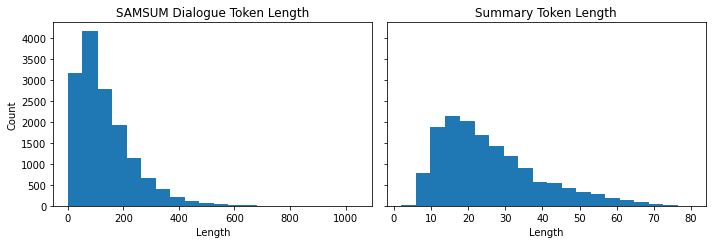

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color='C0', edgecolor='C0')
axes[0].set_title('SAMSUM Dialogue Token Length')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Count')
axes[1].hist(s_len, bins=20, color='C0', edgecolor='C0')
axes[1].set_title('Summary Token Length')
axes[1].set_xlabel('Length')
plt.tight_layout()
plt.show()

In [35]:
d_len = [len(tokenizer.encode(s)) for s in dataset['train'].select(range(100))['article']]
s_len = [len(tokenizer.encode(s)) for s in dataset['train'].select(range(100))['highlights']]

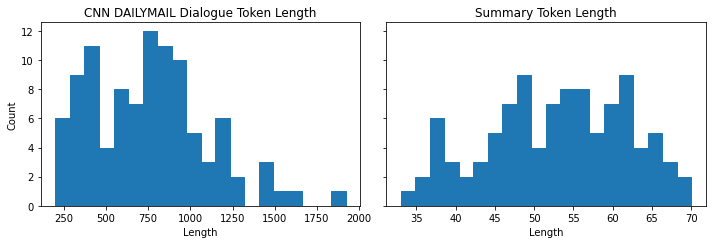

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color='C0', edgecolor='C0')
axes[0].set_title('CNN DAILYMAIL Dialogue Token Length')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Count')
axes[1].hist(s_len, bins=20, color='C0', edgecolor='C0')
axes[1].set_title('Summary Token Length')
axes[1].set_xlabel('Length')
plt.tight_layout()
plt.show()

In [37]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'], max_length=1024,
                                truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length=128,
                                    truncation=True)
    return {'input_ids': input_encodings['input_ids'],
           'attention_mask': input_encodings['attention_mask'],
           'labels': target_encodings['input_ids']}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                      batched=True)
columns = ['input_ids', 'labels', 'attention_mask']
dataset_samsum_pt.set_format(type='torch', columns=columns)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [38]:
ds = dataset_samsum_pt['train'].select(range(3))
def mm_batch(recs):
    input_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in recs['input_ids']]
    labels_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in recs['labels']]
    return {'input_tokens': input_tokens, 'labels_tokens': labels_tokens}

ds2 = ds.map(mm_batch, batched=True)
df = ds2.to_pandas()
display(df[['dialogue', 'summary', 'input_ids', 'labels', 'input_tokens', 'labels_tokens']])

  0%|          | 0/1 [00:00<?, ?ba/s]

,dialogue,summary,input_ids,labels,input_tokens,labels_tokens
0,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,"[12195, 151, 125, 7091, 3659, 107, 842, 119, 2...","[12195, 7091, 3659, 111, 138, 650, 10508, 181,...","[▁Amanda, :, ▁I, ▁baked, ▁cookies, ., ▁Do, ▁yo...","[▁Amanda, ▁baked, ▁cookies, ▁and, ▁will, ▁brin..."
1,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,"[18038, 151, 2632, 127, 119, 6228, 118, 115, 1...","[18038, 111, 34296, 127, 6228, 118, 33195, 115...","[▁Olivia, :, ▁Who, ▁are, ▁you, ▁voting, ▁for, ...","[▁Olivia, ▁and, ▁Olivier, ▁are, ▁voting, ▁for,..."
2,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,"[4776, 151, 4451, 108, 180, 131, 116, 164, 152...","[5377, 218, 508, 109, 891, 93882, 3111, 2087, ...","[▁Tim, :, ▁Hi, ,, ▁what, ', s, ▁up, ?, ▁Kim, :...","[▁Kim, ▁may, ▁try, ▁the, ▁p, omodoro, ▁techniq..."


In [39]:
model_local = 'pegasus-samsum'

if not TRAIN_MODEL:
    model = AutoModelForSeq2SeqLM.from_pretrained(f'olpa/{model_local}').to(device)

In [40]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
training_args = TrainingArguments(
    output_dir = model_local, num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

In [41]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt['train'],
                  eval_dataset=dataset_samsum_pt['validation'])

/home/olpa/p/small_tasks/2022/transformers/pegasus-samsum is already a clone of https://huggingface.co/olpa/pegasus-samsum. Make sure you pull the latest changes with `repo.git_pull()`.


In [42]:
if TRAIN_MODEL:
    trainer.train()
    trainer.push_to_hub('Training complete!')

In [43]:
score = getv('score_trained')
if not score:
    score = evaluate_summaries_pegasus(
        dataset_samsum['test'], rouge_metric, trainer.model, tokenizer,
        batch_size=2, column_text='dialogue', column_summary='summary'
    )
    putv(score, 'score_trained')

In [44]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.441787,0.209993,0.349317,0.349239


# p162 Generating Dialogue Summaries

In [45]:
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, 'max_length': 128}
sample_text = dataset_samsum['test'][0]['dialogue']
reference = dataset_samsum['test'][0]['summary']
pipe = pipeline('summarization', model=f'olpa/{model_local}')

loading configuration file https://huggingface.co/olpa/pegasus-samsum/resolve/main/config.json from cache at /home/olpa/.cache/huggingface/transformers/626603313cf40ca696b010a1f381033898147fe071f5c7970f426aa879c7e2af.b46a75d1f06c6187e9e1e283bc240896e6772d607bc51a4386380939514cf055
Model config PegasusConfig {
  "_name_or_path": "olpa/pegasus-samsum",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_t

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

storing https://huggingface.co/olpa/pegasus-samsum/resolve/main/tokenizer_config.json in cache at /home/olpa/.cache/huggingface/transformers/d4b8c04f3d7efaeed4dec8779ac20d6b19bb8cd5b4e7d7b73e6c36b3621f2d44.6bd7e13d2860a6b55ee2dfa8c312bc6105121c296632ce2fe8b8fcba31fe1e57
creating metadata file for /home/olpa/.cache/huggingface/transformers/d4b8c04f3d7efaeed4dec8779ac20d6b19bb8cd5b4e7d7b73e6c36b3621f2d44.6bd7e13d2860a6b55ee2dfa8c312bc6105121c296632ce2fe8b8fcba31fe1e57
https://huggingface.co/olpa/pegasus-samsum/resolve/main/spiece.model not found in cache or force_download set to True, downloading to /home/olpa/.cache/huggingface/transformers/tmp5b27kir4


Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

storing https://huggingface.co/olpa/pegasus-samsum/resolve/main/spiece.model in cache at /home/olpa/.cache/huggingface/transformers/d62ecd12fd3ff63c59de785004b92502740da974aeba8bf20b3b403452028478.998a78c02c57769973177e597b68eb63a587023acaa1336bbdc49e8c681aaeac
creating metadata file for /home/olpa/.cache/huggingface/transformers/d62ecd12fd3ff63c59de785004b92502740da974aeba8bf20b3b403452028478.998a78c02c57769973177e597b68eb63a587023acaa1336bbdc49e8c681aaeac
https://huggingface.co/olpa/pegasus-samsum/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /home/olpa/.cache/huggingface/transformers/tmphyvn0thc


Downloading:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

storing https://huggingface.co/olpa/pegasus-samsum/resolve/main/tokenizer.json in cache at /home/olpa/.cache/huggingface/transformers/eca6c200cd6496ffe6815a96739f48016c00e888fdc682e563cb65582ff2ff76.1426022f2e186170369cd12cc5573962459a6221f7414abc57680a254d2c33cc
creating metadata file for /home/olpa/.cache/huggingface/transformers/eca6c200cd6496ffe6815a96739f48016c00e888fdc682e563cb65582ff2ff76.1426022f2e186170369cd12cc5573962459a6221f7414abc57680a254d2c33cc
https://huggingface.co/olpa/pegasus-samsum/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /home/olpa/.cache/huggingface/transformers/tmp5gy9vz6r


Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

storing https://huggingface.co/olpa/pegasus-samsum/resolve/main/special_tokens_map.json in cache at /home/olpa/.cache/huggingface/transformers/0fe2c98329e31e841378a5cddb0fd0ed827866c30e1b526b063f3c799b7b8897.d6a458395976c3c3174927747aca890171a59df352e292371bf46aa0bdd6615d
creating metadata file for /home/olpa/.cache/huggingface/transformers/0fe2c98329e31e841378a5cddb0fd0ed827866c30e1b526b063f3c799b7b8897.d6a458395976c3c3174927747aca890171a59df352e292371bf46aa0bdd6615d
loading file https://huggingface.co/olpa/pegasus-samsum/resolve/main/spiece.model from cache at /home/olpa/.cache/huggingface/transformers/d62ecd12fd3ff63c59de785004b92502740da974aeba8bf20b3b403452028478.998a78c02c57769973177e597b68eb63a587023acaa1336bbdc49e8c681aaeac
loading file https://huggingface.co/olpa/pegasus-samsum/resolve/main/tokenizer.json from cache at /home/olpa/.cache/huggingface/transformers/eca6c200cd6496ffe6815a96739f48016c00e888fdc682e563cb65582ff2ff76.1426022f2e186170369cd12cc5573962459a6221f7414abc5768

In [47]:
print('Dialogue:')
print(sample_text)
print('\nReference Summary:')
print(reference)
print('\nMOdel Summary:')
print(pipe(sample_text, **gen_kwargs)[0]['summary_text'])

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

MOdel Summary:
Amanda can't find Betty's number. Larry called her last time they were at the park together. Hannah would rather she text him. Amanda will text him.


In [49]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesone, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]['summary_text'])

Your max_length is set to 128, but you input_length is only 94. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Thom, Lewis and Leandro are going to write a book about transformers. Thom helped build a library by Hugging Face. They are going to do it together.
